In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import FA
import backprop
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =',device)

device = cuda


In [2]:
BATCH_SIZE = 32
loss_crossentropy = torch.nn.CrossEntropyLoss()
loss_mse = torch.nn.MSELoss()

train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                        ])),
                        batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                        ])),
                        batch_size=BATCH_SIZE, shuffle=True)

In [3]:
def angle_measure(FA, BP):

    flattenFA, flattenBP = torch.flatten(FA), torch.flatten(BP)
    value = torch.norm(torch.dot(flattenFA, flattenBP)) / (torch.norm(flattenFA) * torch.norm(flattenBP))
    value = torch.acos(value).item()
    return value


def train_model(model, optimizer, train_loader, num_epochs, criterion, batchSize=32):
    logName = f"{model.__class__.__name__}_{model.num_layers}"
    print("Training", logName)
    logger_train = open(f"logs/{logName}.txt", 'w')
    for epoch in range(1, num_epochs+1):
        for idx_batch, (inputs, targets) in enumerate(train_loader):
            targetVectors = F.one_hot(targets, 10)
            inputs = inputs.view(batchSize, -1)
            inputs, targetVectors = Variable(inputs), Variable(targetVectors)
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targetVectors.to(device).float())
            model.zero_grad()
            loss.backward()
            optimizer.step()

            if (idx_batch + 1) % 100 == 0:
                train_log = 'epoch ' + str(epoch) + ' step ' + str(idx_batch + 1) + \
                            ' loss ' + str(loss.item())
                print(f"epoch {epoch};  step {idx_batch+1}          ", end='\r')
                logger_train.write(train_log + '\n')


def test_model(model, test_loader, criterion):
    print("Testing", model.__class__.__name__, "with", model.num_layers, "layers")
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            targetVectors = F.one_hot(targets, 10)
            inputs = data.view(data.size(0), -1)
            inputs, targetVectors, targets = Variable(inputs), Variable(targetVectors), Variable(targets)
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targetVectors.to(device).float())
            test_loss += loss.item() * inputs.size(0)
            total += targets.size(0)
            correct += (outputs.argmax(dim=1) == targets.to(device)).sum().item()

    test_loss = test_loss / total
    accuracy = 100 * correct / total
    print('Test Loss: {:.4f}'.format(test_loss))
    print('Accuracy: {:.2f}%'.format(accuracy)) 


def train_2_models(modelFA, modelBP, optimizerFA,optimizerBP , train_loader, num_epochs, criterion, batchSize=32):
    logName = f"{modelFA.__class__.__name__}_{modelFA.num_layers}"
    print("Training", logName)
    logger_train = open(f"logs/{logName}.txt", 'w')
    angles = []
    lossesFA = []
    lossesBP = []
    for epoch in range(1, num_epochs+1):
        for idx_batch, (inputs, targets) in enumerate(train_loader):
            targetVectors = F.one_hot(targets, 10)
            inputs = inputs.view(batchSize, -1)
            inputs, targetVectors = Variable(inputs).to(device), Variable(targetVectors).to(device)
            outputsFA = modelFA(inputs)
            outputsBP = modelBP(inputs)
            errorFA = (targetVectors - outputsFA).to(device)
            errorBP = (targetVectors - outputsBP).to(device)
            lossFA = criterion(outputsFA, targetVectors.float())
            lossBP = criterion(outputsBP, targetVectors.float())
            modelFA.zero_grad()
            modelBP.zero_grad()
            lossFA.backward()
            lossBP.backward()
            optimizerFA.step()
            optimizerBP.step()

            if (idx_batch + 1) % 100 == 0:
                matriceFA = torch.mm(errorFA, modelFA.linear[-1].weight_fa.to(device))
                matriceBP = torch.mm(errorFA, modelFA.linear[-1].weight.to(device))
                angle = angle_measure(matriceFA, matriceBP)
                angles.append(angle)
                lossesFA.append(lossFA.item())
                lossesBP.append(lossBP.item())
                
                train_log = 'epoch ' + str(epoch) + ' step ' + str(idx_batch + 1) + \
                            ' lossFA ' + str(lossFA.item()) + ' lossBP ' + str(lossFA.item()) + ' angle '+ str(angle)
                print(f"epoch {epoch};  step {idx_batch+1}          ", end='\r')
                logger_train.write(train_log + '\n')

    return angles, lossesFA, lossesBP


In [4]:
model_fa = FA.FANetwork(in_features=784, num_layers=3, num_hidden_list=[1000, 30, 10], activation_function=F.tanh).to(device)
optimizer_fa = torch.optim.SGD(model_fa.parameters(),lr=1e-4, momentum=0.9, weight_decay=0.001, nesterov=True)
model_bp = backprop.BackPropNetwork(in_features=784, num_layers=3, num_hidden_list=[1000, 30, 10]).to(device)
optimizer_bp = torch.optim.SGD(model_bp.parameters(),lr=1e-4, momentum=0.9, weight_decay=0.001, nesterov=True)
angles, lossesFA, lossesBP = train_2_models(model_fa, model_bp, optimizer_fa, optimizer_bp,train_loader, num_epochs=100, criterion=loss_mse, batchSize=BATCH_SIZE)

Training FANetwork_3


In [5]:
angles2 = [angle*180/3.14 for angle in angles]

Text(0, 0.5, 'Angle entre les matrices de poids')

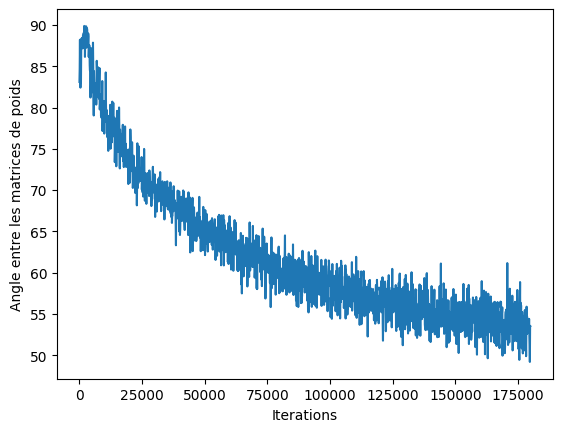

In [11]:
plt.plot([100*i for i in range(len(angles2))], angles2)
plt.xlabel('Iterations')
plt.ylabel('Angle entre les matrices de poids')

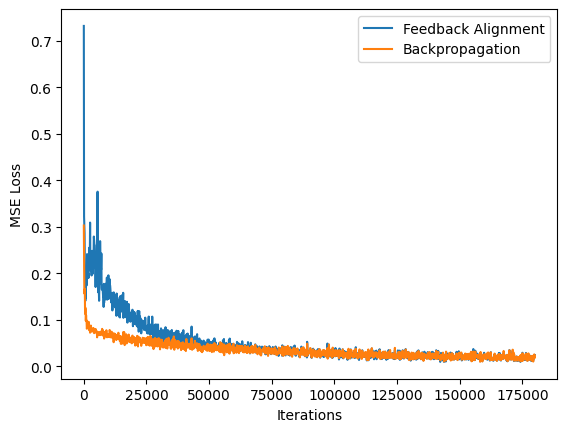

In [7]:
plt.plot([100*i for i in range(len(lossesFA))], lossesFA)
plt.plot([100*i for i in range(len(lossesBP))], lossesBP)
plt.legend(['Feedback Alignment', 'Backpropagation'])
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.show()

In [8]:
print("Testing Feedforward DFA Model...")
test_model(model_fa, test_loader, loss_mse)

Testing Feedforward DFA Model...
Testing FANetwork with 3 layers
Test Loss: 0.0182
Accuracy: 93.45%


In [9]:
print("\nTesting BackProp Model...")
test_model(model_bp, test_loader, loss_mse)


Testing BackProp Model...
Testing BackPropNetwork with 3 layers
Test Loss: 0.0184
Accuracy: 93.44%
